The work presented in this notebook is based on the paper:

`Quantum Amplitude Amplification and Estimation` https://arxiv.org/abs/quant-ph/0005055.

# Imports

In [1]:
# To install Qiskit, uncomment and run the line below
# !pip install -r requirements.txt --quiet

# If you haven't used your IBMQ account yet, load it using your TOKEN:
# IBMQ.save_account(TOKEN)

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute
from qiskit.quantum_info.operators import Operator
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Provider and backends

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
backend_qc = provider.get_backend('ibmq_manila')
backend_qc_sim = QasmSimulator.from_backend(backend_qc)

# Amplitude Amplification

In the paper it's shown that if one has a state $\left\vert \psi\right\rangle $
that was generated by a unitary transformation as $\left\vert \psi\right\rangle =\mathcal{A}\left\vert 0\right\rangle $,
and it can be written as $\left\vert \psi\right\rangle =\left\vert \psi_{1}\right\rangle +\left\vert \psi_{0}\right\rangle $,
where it is our goal to amplify the state $\left\vert \psi_{1}\right\rangle $
(i.e. shift more probability mass to it s.t. it is measured with higher
probability), then that can be done by repeated application of the
operator $Q=-\mathcal{A}S_{0}\mathcal{A}^{\dagger}S_{\chi}$, where
$S_{0}$ flips the sign only of the zero state and $S_{\chi}$ flips
the sign only of the desired state. This works because the $m^{\text{th}}$
iteration is:
$$
Q^{m}\left\vert \psi\right\rangle =\frac{1}{\sqrt{a}}\sin\left(\left(2m+1\right)\theta_{a}\right)\left\vert \psi_{1}\right\rangle +\frac{1}{\sqrt{1-a}}\cos\left(\left(2m+1\right)\theta_{a}\right)\left\vert \psi_{0}\right\rangle 
$$
where $\theta_{a}\in\left[0,\frac{\pi}{2}\right]$ is defined s.t.
$\sin\left(\theta_{a}\right)=a=\left\langle \psi_{1}\vert\psi_{1}\right\rangle $,
which means that $\left\vert \psi_{1}\right\rangle $ will be measured
with probability $\sin^{2}\left(\left(2j+1\right)\theta_{a}\right)$.
It is desired that this probability is close to 1, and that can be
achieved by setting $m=\lfloor\frac{\pi}{4\theta_{a}}\rfloor$, which
will produce a good outcome with probability at least $\max\left(1-a,a\right)$.

The first thing we have to do then choose a state $\left\vert \psi\right\rangle$. 

Let's generate a random $\mathcal{A}$ circuit, and its respective $\mathcal{A}^{\dagger}$.

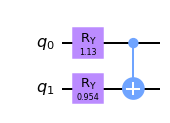

In [4]:
A = QuantumCircuit(2)
theta0, theta1 = np.random.random(2) * np.pi
A.ry(theta0, 0)
A.ry(theta1, 1)
A.cx(0, 1)
A.draw()

In [5]:
qc = deepcopy(A)
qc.measure_all()
job = execute(qc, backend=backend_sim, shots=20000)
job.result().get_counts()

{'01': 1231, '11': 4571, '00': 11210, '10': 2988}

We see that this state is not an equal superposition of all basis states, a requirement for the standard Grover algoritm (SGA) to work. We will see that this amplification method alows us to still measure a desired basis state with high probability.

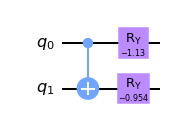

In [6]:
Adg = QuantumCircuit(2)
Adg.cx(0, 1)
Adg.ry(-theta0, 0)
Adg.ry(-theta1, 1)
Adg.draw()

Let's quickly check that if we compose these two together we get the identity.

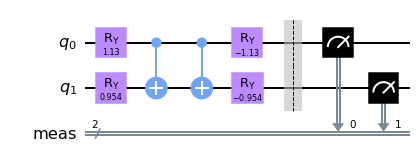

In [7]:
check0 = QuantumCircuit(2)
check0.compose(A, inplace=True)
check0.compose(Adg, inplace=True)
check0.measure_all()
check0.draw()

In [8]:
job = execute(check0, backend=backend_sim, shots=20000)
job.result().get_counts()

{'00': 20000}

We only get the '00' state as expected.

For simplicity, let's say the oracle selects the state $\left\vert 11 \right\rangle$ to be the correct solution to the search problem.

Let's now build the rest of the necessary operators, i.e. the oracle and the diffusion operator.

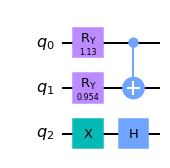

In [9]:
init = QuantumCircuit(3)
init.compose(A, inplace=True)
init.x(2)
init.h(2)
init.draw()

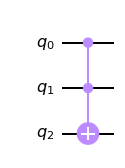

In [10]:
oracle = QuantumCircuit(3)
oracle.ccx(0, 1, 2)
oracle.draw()

The diffusion operator is $\mathcal{A}S_{0}\mathcal{A}^{\dagger}$, where $S_{0}$ is the operator that flips the sign of the zero state.
The `barriers` in the following cell are present just to make the individual operators that constitute it visually clear, and are removed in cell after.

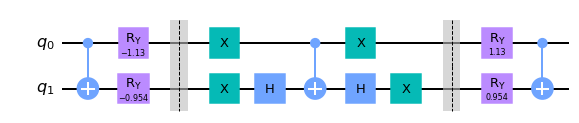

In [11]:
diffusion = QuantumCircuit(2)
diffusion.compose(Adg, inplace=True)
diffusion.barrier()
diffusion.x([0, 1])
diffusion.h(1)
diffusion.cx(0, 1)
diffusion.h(1)
diffusion.x([0, 1])
diffusion.barrier()
diffusion.compose(A, inplace=True)
diffusion.draw()

In [12]:
diffusion = RemoveBarriers()(diffusion)

The grover operator consists of first applying the oracle and then the (generalized) diffusion operator.

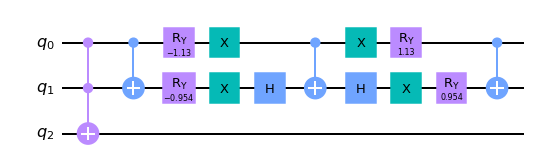

In [13]:
grover = QuantumCircuit(3)
grover.compose(oracle, inplace=True)
grover.compose(diffusion, inplace=True)
grover.draw()

Finally we can build a list of circuits, where the $i$th circuit has $i$ grover iterations.

In [14]:
circ_lst = []

qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(2, 'c')
circ = QuantumCircuit(qr, cr)

circ.compose(init, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.barrier()
circ_temp.measure(qr[:2], cr)
circ_lst.append(circ_temp)

for i in range(10):
    circ.compose(grover, inplace=True)
    circ_temp = deepcopy(circ)
    circ_temp.barrier()
    circ_temp.measure(qr[:2], cr)
    circ_lst.append(circ_temp)

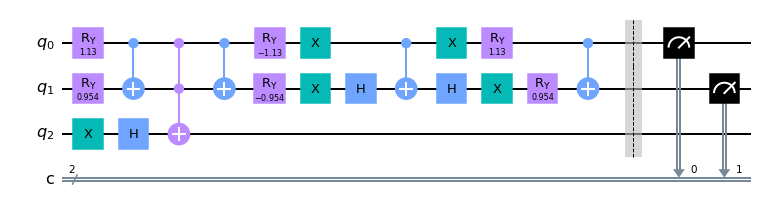

In [15]:
circ_lst[1].draw()

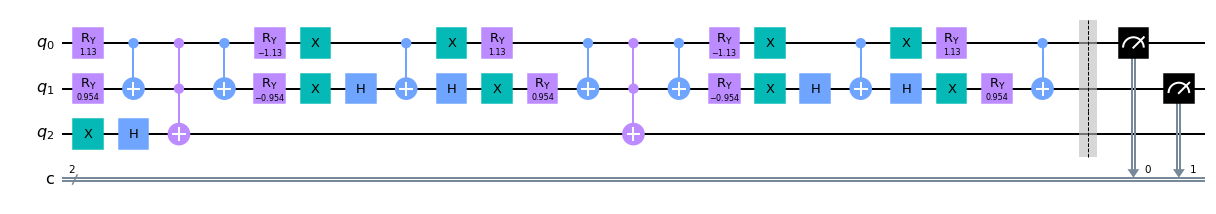

In [16]:
circ_lst[2].draw()

In [17]:
job = execute(circ_lst, backend=backend_sim, shots=20000)

def success_probabilities(counts):
    probs = []
    for c in counts:
        probs.append(c.get('11', 0)/20000)
    return probs

success_probs = success_probabilities(job.result().get_counts())
print(success_probs)

[0.23205, 0.9946, 0.3694, 0.11235, 0.943, 0.53185, 0.03395, 0.85385, 0.67885, 0.00055, 0.73035]


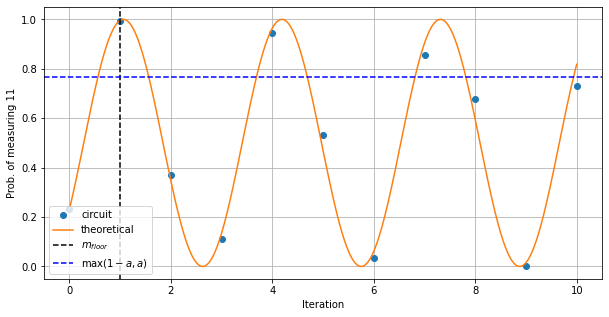

In [18]:
def plot_analysis(probs):
    a = probs[0]
    theta = np.arcsin(np.sqrt(a))
    m = np.arange(len(probs))
    ms = np.linspace(m[0], m[-1], 1000)
    
    plt.figure(figsize=(10, 5))
    plt.xlabel('Iteration')
    plt.ylabel('Prob. of measuring 11')
    plt.plot(success_probs, 'o', label='circuit')
    plt.plot(ms, np.sin((2*ms+1)*theta)**2, label='theoretical')
    plt.axvline(x=np.floor(np.pi/(4*theta)), c='k', ls='--', label=r'$m_{floor}$')
    plt.axhline(y=max(a, 1-a), c='b', ls='--', label=r'max$(1-a,a)$')
    plt.grid()
    plt.legend()
    plt.show()
    
plot_analysis(success_probs)

We see that the number of iterations marked by the vertical black line maximize the probability of measuring our desired basis state. However, this was run in a simulator, let's run this in an actual quantum computer.

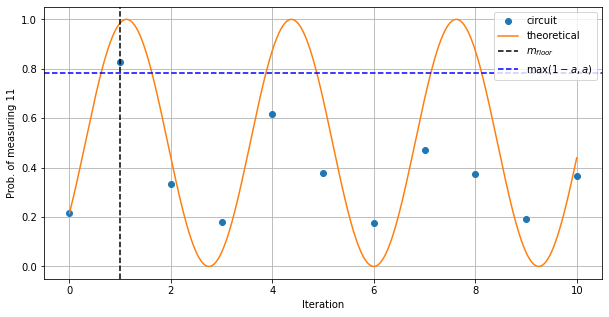

In [19]:
# job = execute(circ_lst, backend=backend_qc, shots=20000) # 61cb0b903b5b8442361039c3
# job_monitor(job)

job = execute(circ_lst, backend=backend_qc_sim, shots=20000)

In [ ]:
success_probs = success_probabilities(job.result().get_counts())
plot_analysis(success_probs)

As expected, the noise present in `ibmq_manila` deviates the results from the theory, but we can still achieve a satisfactory probability of measuring our desired state.

In [20]:
%qiskit_version_table